In [ ]:
import json
from copy import deepcopy
from pprint import pprint

with open("reformat_metaculus_questions.json") as file:
    data = json.load(file)
len(data)

4903

In [4]:
from datetime import datetime

def parse_date(date_string):
    return datetime.strptime(date_string, '%m/%d/%Y')

remove_topic = ["bitcoin"]

def valid_market(market, start_date):
    if market['resolved'] != True:
        return False
    
    if any(topic in market['question']['title'].lower() for topic in remove_topic):
        return False
    
    if 'binary' not in market['question']['type'].lower():
        return False
    if market['question']['resolution'] not in ['yes', 'no']:
        return False
    if market['nr_forecasters'] < 20:
        return False
    
    try:
        # Try the format without microseconds first
        market_resolve_time = datetime.strptime(market['actual_close_time'], '%Y-%m-%dT%H:%M:%SZ')
    except ValueError:
        # If that fails, try the format with microseconds
        market_resolve_time = datetime.strptime(market['actual_close_time'], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    try:
        published_time = datetime.strptime(market['published_at'], '%Y-%m-%dT%H:%M:%S.%fZ')
    except:
        published_time = datetime.strptime(market['published_at'], '%Y-%m-%dT%H:%M:%SZ')
    
    try:
        close_time = datetime.strptime(market['actual_close_time'], '%Y-%m-%dT%H:%M:%S.%fZ')
    except:
        close_time = datetime.strptime(market['actual_close_time'], '%Y-%m-%dT%H:%M:%SZ')
        
    return close_time >= start_date

start_date_str = "11/01/2024"
start_date = parse_date(start_date_str)

filtered_data = []
for m in data:
    if valid_market(m, start_date):
        filtered_data.append(m)
        
# print(len(data), len(filtered_data))
len(filtered_data)

540

In [73]:
from datetime import datetime, timedelta
import bisect

def process_community_predictions(community_prediction, n=5,cutoff_date):
    if not community_prediction:
        return []

    # Sort community_prediction by timestamp
    community_prediction.sort(key=lambda x: x['start_time'])
    
    if cutoff_date:
        cutoff_date = datetime.strptime(cutoff_date, "%m/%d/%Y")
        cutoff_timestamp = cutoff_date.timestamp()

    # Get start and end dates from the first and last predictions
    start_dt = datetime.fromtimestamp(community_prediction[0]['start_time'])
    end_dt = datetime.fromtimestamp(community_prediction[-1]['start_time'])

    # Calculate total days
    total_days = (end_dt - start_dt).days

    # Calculate chunk end dates
    chunk_dates = [start_dt + timedelta(days=int((total_days ** (k/n)) - 1)) for k in range(1, n+1)]

    # Extract timestamps and crowd predictions
    timestamps = [pred['start_time'] for pred in community_prediction]
    forecaster_counts = [pred['forecaster_count'] for pred in community_prediction]
    crowd_preds = [pred['means'] for pred in community_prediction]

    result = []
    for chunk_date in chunk_dates:
        chunk_timestamp = chunk_date.timestamp()

        # Find the index of the last prediction before or at the chunk date
        idx = bisect.bisect_right(timestamps, chunk_timestamp) - 1

        if idx >= 0:
            result.append([
                int(timestamps[idx] * 1000),  # Convert to milliseconds
                datetime.fromtimestamp(timestamps[idx]).strftime('%Y-%m-%d'),
                forecaster_counts[idx],
                crowd_preds[idx][0]
            ])

    return result

process_data = []
brier_scores = [[] for _ in range(5)]
resolution_criterias = []
for m in deepcopy(filtered_data):
    community_prediction = deepcopy(m['question']['aggregations']['recency_weighted']['history'])
    resolution_criteria=  deepcopy(m['question']['resolution_criteria'])
    del m['question']['aggregations']
    question = m['title']
    background_text = m['description']
    close_time = m['actual_close_time']
    created_time = m['published_at']

    resolution_criterias.append(dict(background_text=background_text, resolution_criteria=resolution_criteria))

    try:
        resolve_time_ts = int(datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%SZ').timestamp() * 1000)
        resolve_time_str = datetime.fromtimestamp(resolve_time_ts / 1000).strftime('%Y-%m-%d')
    except:
        resolve_time_ts = int(datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp() * 1000)
        resolve_time_str = datetime.fromtimestamp(resolve_time_ts / 1000).strftime('%Y-%m-%d')

    try:                   
        created_time_ts = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp() * 1000
    except:
        created_time_ts = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%SZ').timestamp() * 1000

    try:
        close_time_ts = datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp() * 1000
    except:
        close_time_ts = datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%SZ').timestamp() * 1000

    created_time_str = datetime.fromtimestamp(created_time_ts / 1000).strftime('%Y-%m-%d')
    close_time_str = datetime.fromtimestamp(close_time_ts / 1000).strftime('%Y-%m-%d')

    resolution = m['question']['resolution'] == 'yes'
    crow_preds = process_community_predictions(community_prediction)
    preds = [p[-1] for p in crow_preds]
    scores = [(_p - resolution) ** 2 for _p in preds]
    if len(crow_preds) != 5:
        continue
    for i in range(5):
        brier_scores[i].append(scores[i])
        
    market=dict(question=question, 
                background_text=background_text, 
                createdTime=created_time,
                createdTimeStr=created_time_str,
                closeTimeStr=close_time_str,
                resolutionTime=resolve_time_ts,
                resolveTimeStr=resolve_time_str,
                resolution=resolution,
                crowd_pred=crow_preds)

    # print("resolution=", resolution)
    # pprint(m)
    process_data.append(market)
len(process_data)

223

In [146]:
from datetime import datetime, timedelta
import bisect

def process_community_predictions(community_prediction, n=5,cutoff_date=None):
    if not community_prediction:
        return []

    # Sort community_prediction by timestamp
    community_prediction.sort(key=lambda x: x['start_time'])
    
    if cutoff_date:
        cutoff_date = datetime.strptime(cutoff_date, "%m/%d/%Y")
        cutoff_timestamp = cutoff_date.timestamp()

    # Get start and end dates from the first and last predictions
    start_dt = datetime.fromtimestamp(community_prediction[0]['start_time'])
    end_dt = datetime.fromtimestamp(community_prediction[-1]['start_time'])

    # Calculate total days
    total_days = (end_dt - start_dt).days

    # Calculate chunk end dates
    chunk_dates = [start_dt + timedelta(days=int((total_days ** (k/n)) - 1)) for k in range(1, n+1)]

    # Extract timestamps and crowd predictions
    timestamps = [pred['start_time'] for pred in community_prediction]
    forecaster_counts = [pred['forecaster_count'] for pred in community_prediction]
    crowd_preds = [pred['means'] for pred in community_prediction]

    if len(chunk_dates) < 5:
        return None

    for i, ts in enumerate(timestamps):
        pred = crowd_preds[i][0]
        # print(abs(1-pred))
        if ts > cutoff_timestamp and forecaster_counts[i] >= 20:
            return [
                int(timestamps[i] * 1000),  # Convert to milliseconds
                datetime.fromtimestamp(timestamps[i]).strftime('%Y-%m-%d'),
                forecaster_counts[i],
                crowd_preds[i][0]
            ]
    
    return None  # Return None if no prediction after cutoff date


process_data = []
brier_scores = []
cors = []
resolution_criterias = []
dates =[]
cutoff_date = "11/01/2024"

# with open("backend/src/benchmarks/data/metaculus_sample_val_1101.json", "r") as file:
#     data = json.load(file)

for m in deepcopy(filtered_data):
    community_prediction = deepcopy(m['question']['aggregations']['recency_weighted']['history'])
    resolution_criteria=  deepcopy(m['question']['resolution_criteria'])
    del m['question']['aggregations']
    question = m['title']
    background_text = m['description']
    close_time = m['actual_close_time']
    created_time = m['published_at']

    resolution_criterias.append(dict(background_text=background_text, resolution_criteria=resolution_criteria))

    try:
        resolve_time_ts = int(datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%SZ').timestamp() * 1000)
        resolve_time_str = datetime.fromtimestamp(resolve_time_ts / 1000).strftime('%Y-%m-%d')
    except:
        resolve_time_ts = int(datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp() * 1000)
        resolve_time_str = datetime.fromtimestamp(resolve_time_ts / 1000).strftime('%Y-%m-%d')

    try:                   
        created_time_ts = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp() * 1000
    except:
        created_time_ts = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%SZ').timestamp() * 1000

    try:
        close_time_ts = datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp() * 1000
    except:
        close_time_ts = datetime.strptime(close_time, '%Y-%m-%dT%H:%M:%SZ').timestamp() * 1000

    created_time_str = datetime.fromtimestamp(created_time_ts / 1000).strftime('%Y-%m-%d')
    close_time_str = datetime.fromtimestamp(close_time_ts / 1000).strftime('%Y-%m-%d')

    resolution = m['question']['resolution'] == 'yes'
    crow_preds = process_community_predictions(community_prediction, cutoff_date=cutoff_date)
    if crow_preds is None:
        continue
    # print(crow_preds)
    pred = crow_preds[-1]
    
    # if pred < 0.1 or pred > 0.9:
    #     continue

    scores = (pred - resolution) ** 2
    brier_scores.append(scores)
    cors.append((pred > 0.5) == resolution)
    dates.append(crow_preds[1])
    
        
    market=dict(question=question, 
                background_text=background_text,
                resolution_criteria=resolution_criteria,
                createdTime=created_time,
                createdTimeStr=created_time_str,
                closeTimeStr=close_time_str,
                resolutionTime=resolve_time_ts,
                resolveTimeStr=resolve_time_str,
                resolution=resolution,
                crowd_pred=[crow_preds])

    # print("resolution=", resolution)
    # pprint(m)
    process_data.append(market)
print(len(process_data), np.mean(brier_scores), np.mean(cors))
# print(f"Average prediction date: {datetime.fromtimestamp(sum(datetime.strptime(d, '%Y-%m-%d').timestamp() for d in dates) / len(dates)).strftime('%Y-%m-%d')} (± {np.std([(datetime.strptime(d, '%Y-%m-%d') - datetime.fromtimestamp(sum(datetime.strptime(d2, '%Y-%m-%d').timestamp() for d2 in dates) / len(dates))).days for d in dates]):.1f} days)")


529 0.13038458981904782 0.8128544423440454


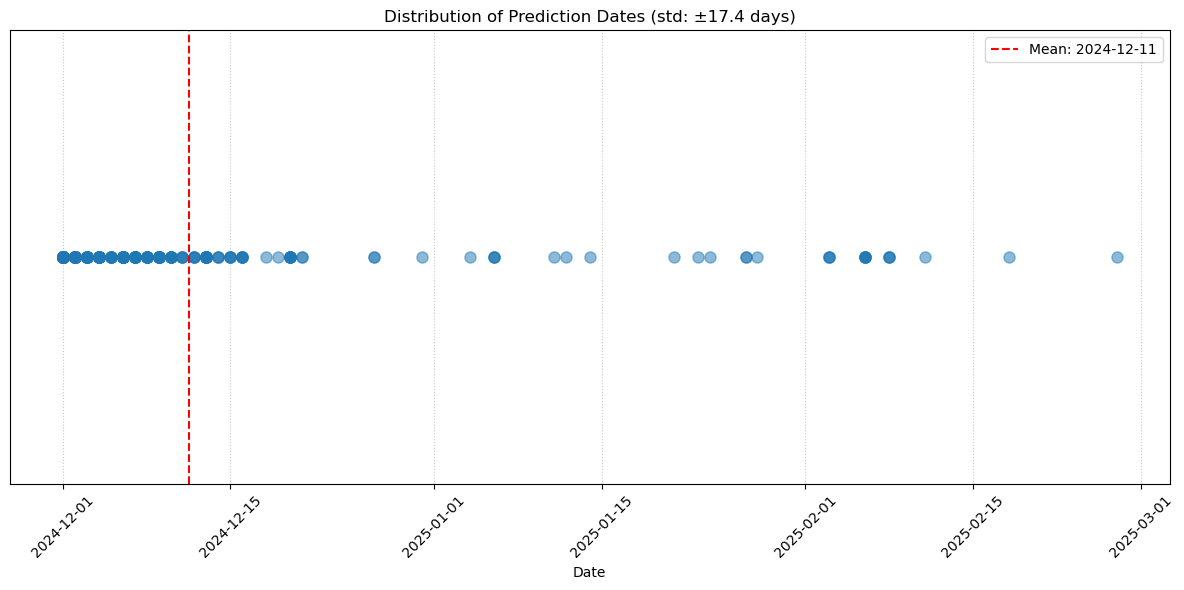

In [132]:
pred_dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates]

# Create the plot
plt.figure(figsize=(12, 6))

# Create y-values (just zeros since we want all points on same line)
y = np.zeros(len(pred_dates))

# Plot the dates
plt.plot(pred_dates, y, 'o', markersize=8, alpha=0.5)

# Calculate and plot the mean date
mean_date = datetime.fromtimestamp(sum(d.timestamp() for d in pred_dates) / len(pred_dates))
plt.axvline(x=mean_date, color='r', linestyle='--', 
            label=f'Mean: {mean_date.strftime("%Y-%m-%d")}')

# Calculate std dev
std_days = np.std([(d - mean_date).days for d in pred_dates])

plt.title(f'Distribution of Prediction Dates (std: ±{std_days:.1f} days)', fontsize=12)
plt.xlabel('Date')

# Remove y-axis as it's not meaningful
plt.gca().set_yticks([])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True, axis='x', linestyle=':', alpha=0.7)
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [67]:
with open("resolution_criteria.json", "w") as file:
    json.dump(resolution_criterias, file,indent=2)

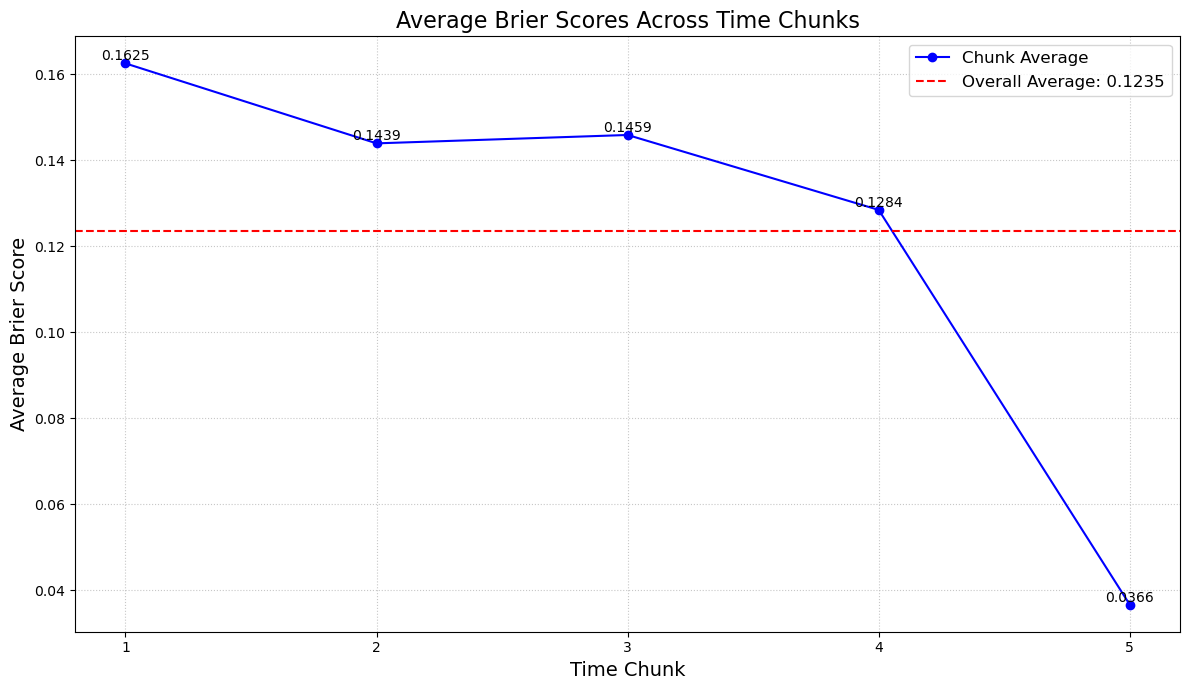

Average Brier Scores:
Chunk 1: 0.1625
Chunk 2: 0.1439
Chunk 3: 0.1459
Chunk 4: 0.1284
Chunk 5: 0.0366
Overall Average: 0.1235


In [65]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt

# Calculate average Brier scores for each chunk
avg_brier_scores = [np.mean(scores) for scores in brier_scores if scores]

# Calculate overall average Brier score
overall_avg_brier_score = np.mean(avg_brier_scores)

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(avg_brier_scores) + 1), avg_brier_scores, marker='o', color='blue', label='Chunk Average')
plt.axhline(y=overall_avg_brier_score, color='r', linestyle='--', label=f'Overall Average: {overall_avg_brier_score:.4f}')

plt.title('Average Brier Scores Across Time Chunks', fontsize=16)
plt.xlabel('Time Chunk', fontsize=14)
plt.ylabel('Average Brier Score', fontsize=14)
plt.xticks(range(1, len(avg_brier_scores) + 1))
plt.grid(True, linestyle=':', alpha=0.7)

# Add value labels for chunk averages
for i, score in enumerate(avg_brier_scores):
    plt.text(i+1, score, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('brier_scores_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print("Average Brier Scores:")
for i, score in enumerate(avg_brier_scores):
    print(f"Chunk {i+1}: {score:.4f}")
print(f"Overall Average: {overall_avg_brier_score:.4f}")

In [149]:
import random
import json

# Set a random seed for reproducibility
random.seed(0)

# Shuffle the data
random.shuffle(process_data)

# Calculate the split point
split_point = len(process_data) // 2

# Split the data
val_data = process_data[:split_point]
test_data = process_data[split_point:]

for set in [val_data, test_data]:
    # Calculate accuracy and Brier score for each set
    correct = 0
    brier_score = 0
    n = 0
    
    for market in set:
        if 'resolution' in market and 'crowd_pred' in market and market['crowd_pred']:
            # Get the final prediction
            final_pred = market['crowd_pred'][-1][3]
            total_forecasters = market['crowd_pred'][-1][2]
            if isinstance(final_pred, list):
                final_pred = final_pred[0]

            # Get actual outcome
            actual = 1.0 if market['resolution'] else 0.0
            
            # Update metrics
            correct += (round(final_pred) == actual)
            brier_score += (final_pred - actual) ** 2
            n += 1
            
    # Compute averages
    accuracy = correct / n if n > 0 else 0
    avg_brier = brier_score / n if n > 0 else 0
    
    print(f"Set size: {len(set)}")
    print(f"Number of markets with predictions: {n}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Brier Score: {avg_brier:.4f}")
    print()

# Save validation data
with open(f"backend/src/benchmarks/data/metaculus_sample_val_1101_min20.json", "w") as file:
    json.dump(val_data, file, indent=2)

# Save test data
with open(f"backend/src/benchmarks/data/metaculus_sample_test_1101_min20.json", "w") as file:
    json.dump(test_data, file, indent=2)

print(f"Saved {len(val_data)} markets to validation set")
print(f"Saved {len(test_data)} markets to test set")

Set size: 264
Number of markets with predictions: 264
Accuracy: 0.8030
Brier Score: 0.1278

Set size: 265
Number of markets with predictions: 265
Accuracy: 0.8226
Brier Score: 0.1330

Saved 264 markets to validation set
Saved 265 markets to test set


In [55]:
process_data[-1]

{'question': 'Will someone hold their breath for more than 30 minutes before 2025?',
 'background_text': 'The Guinness World Records reports that freediver Aleix Segura Vendrell currently (as of March 2018) holds the [world record for breath holding](http://www.guinnessworldrecords.com/world-records/longest-time-breath-held-voluntarily-(male)), clocking in at a mind-numbing 24 minutes, 3:45 seconds on February 28, 2016.\n\nThat busted other previous records, such as magician David Blaine’s impressive 17 minute breath hold. Amazing details on Blaine’s feat are available in this [TED Talk](https://www.ted.com/talks/david_blaine_how_i_held_my_breath_for_17_min) \n\nAll very nice. But bioengineering will allow us to push the record up—possibily, way up. Some techniques, like “lung packing,” are already being put to use by daredevils. [Per Deadspin](https://deadspin.com/how-long-can-humans-hold-their-breath-1467541916): \n\n> This [lung packing] consists of inhaling the very largest breath 

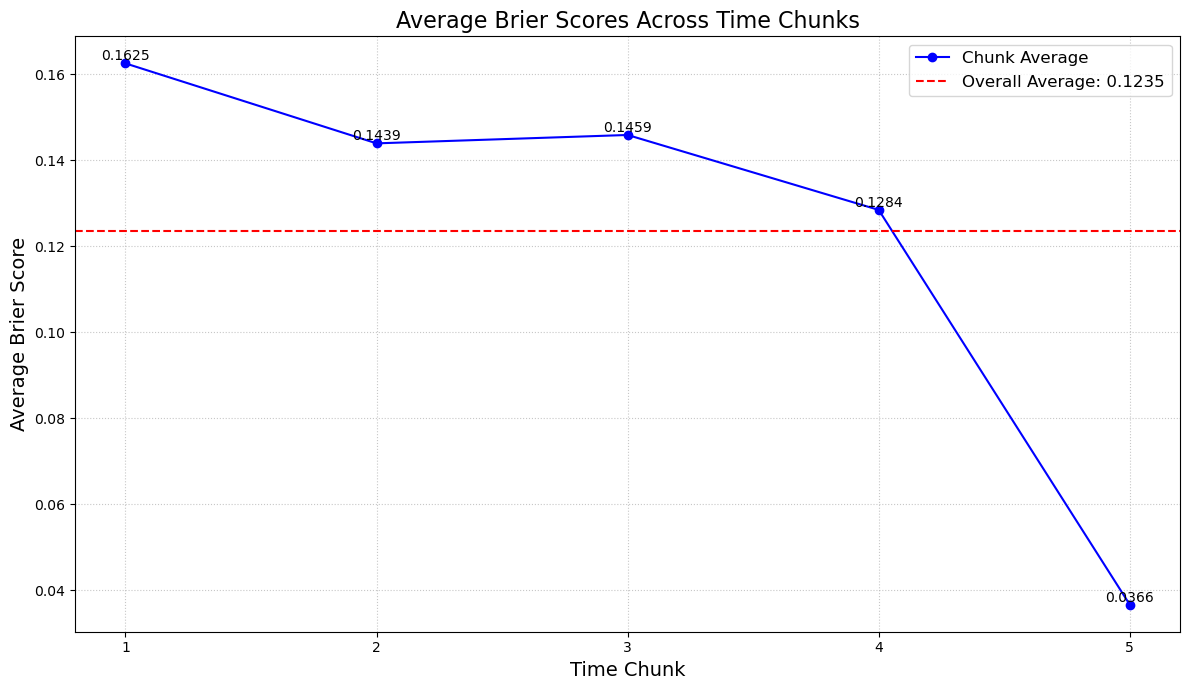

Average Brier Scores:
Chunk 1: 0.1625
Chunk 2: 0.1439
Chunk 3: 0.1459
Chunk 4: 0.1284
Chunk 5: 0.0366
Overall Average: 0.1235


In [50]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt

# Calculate average Brier scores for each chunk
avg_brier_scores = [np.mean(scores) for scores in brier_scores if scores]

# Calculate overall average Brier score
overall_avg_brier_score = np.mean(avg_brier_scores)

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(avg_brier_scores) + 1), avg_brier_scores, marker='o', color='blue', label='Chunk Average')
plt.axhline(y=overall_avg_brier_score, color='r', linestyle='--', label=f'Overall Average: {overall_avg_brier_score:.4f}')

plt.title('Average Brier Scores Across Time Chunks', fontsize=16)
plt.xlabel('Time Chunk', fontsize=14)
plt.ylabel('Average Brier Score', fontsize=14)
plt.xticks(range(1, len(avg_brier_scores) + 1))
plt.grid(True, linestyle=':', alpha=0.7)

# Add value labels for chunk averages
for i, score in enumerate(avg_brier_scores):
    plt.text(i+1, score, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('brier_scores_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print("Average Brier Scores:")
for i, score in enumerate(avg_brier_scores):
    print(f"Chunk {i+1}: {score:.4f}")
print(f"Overall Average: {overall_avg_brier_score:.4f}")

In [53]:
# Calculate average time differences between chunks
time_diffs = []
for market in process_data:
    market_diffs = []
    pred_dates = [datetime.fromtimestamp(p[0]/1000) for p in market['crowd_pred']]
    for i in range(len(pred_dates)-1):
        diff_days = (pred_dates[i+1] - pred_dates[i]).days
        market_diffs.append(diff_days)
    if len(market_diffs) == 4:  # Ensure we have all 4 differences
        for i, diff in enumerate(market_diffs):
            if len(time_diffs) <= i:
                time_diffs.append([])
            time_diffs[i].append(diff)

avg_time_diffs = [np.mean(diffs) for diffs in time_diffs]
print("\nAverage days between chunks:")
for i, diff in enumerate(avg_time_diffs):
    print(f"Time between chunk {i+1} and {i+2}: {diff:.1f} days")


Average days between chunks:
Time between chunk 1 and 2: 6.7 days
Time between chunk 2 and 3: 27.7 days
Time between chunk 3 and 4: 115.4 days
Time between chunk 4 and 5: 473.0 days
